In [1]:
using Pkg 
Pkg.activate(".")

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using ReactiveMP,RxInfer,GraphPPL
using Random, Distributions, LinearAlgebra, SpecialFunctions, Plots, StableRNGs, DomainSets 
using Zygote, Optim, ForwardDiff
using KernelFunctions, LoopVectorization
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix, kernelmatrix! 
import ReactiveMP: approximate_meancov, SphericalRadialCubature, log2π, WishartMessage

┌ Warning: Error requiring `Zygote` from `ReactiveMP`
│   exception = (LoadError("/Users/nguyenhuuminhhoang/.julia/packages/ReactiveMP/EJoCQ/ext/ReactiveMPZygoteExt/ReactiveMPZygoteExt.jl", 1, ArgumentError("Package ReactiveMP does not have Zygote in its dependencies:\n- You may have a partially installed environment. Try `Pkg.instantiate()`\n  to ensure all packages in the environment are installed.\n- Or, if you have ReactiveMP checked out for development and have\n  added Zygote as a dependency but haven't updated your primary\n  environment's manifest file, try `Pkg.resolve()`.\n- Otherwise you may need to report an issue with ReactiveMP")), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x000000016860c66f, Ptr{Nothing} @0x000000016860c83b, Ptr{Nothing} @0x0000000102b0d2a3, Ptr{Nothing} @0x0000000102b4290b, Ptr{Nothing} @0x0000000102b41717, Ptr{Nothing} @0x0000000102b41a93, Ptr{Nothing} @0x0000000102b42073, Ptr{Nothing} @0x0000000102b42e07, Ptr{Nothing} @0x00000001391e7ed7, 

In [3]:
N = 300
max_time = 3
Δt = max_time / (N-1)

function transition_function(x_prev)
    x_1 = x_prev[1] + x_prev[2] * Δt 
    x_2 = x_prev[2] - 9.81 * sin(x_prev[1]) * Δt
    return [x_1, x_2]
end

function generate_data(n,x_init, Q, P;rng = MersenneTwister(124))
    x_prev = x_init  #initial angle and angular velocity
    x = Vector{Vector{Float64}}(undef, n)
    y = Vector{Vector{Float64}}(undef, n)
    for i in 1:n
        x[i] = transition_function(x_prev) + rand(rng, MvNormal(zeros(2),Q))
        y[i] = x[i] + rand(rng, MvNormal(zeros(2),P))
        x_prev = x[i]
    end
    return x, y 
end

generate_data (generic function with 1 method)

In [4]:
qc = 0.01
Q = [qc*Δt^3/3 qc*Δt^2/2;qc*Δt^2/2 qc*Δt]

P = 0.1*diageye(2)     #variance 
H = [1,0]
x_init = [1.5, 0.]

x_state, y_data = generate_data(N,x_init, Q,P);
time_interval = collect(0:Δt:max_time)
;

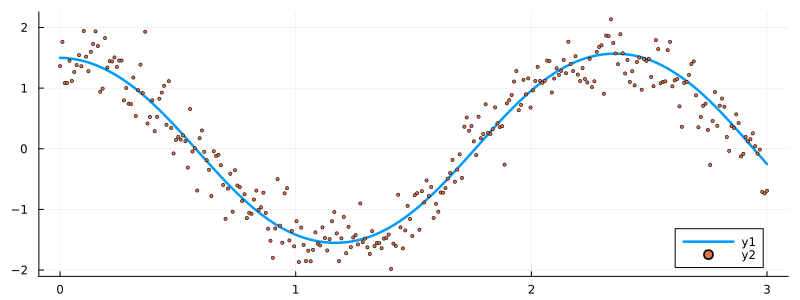

In [5]:
plot(time_interval, getindex.(x_state,1), lw=2.5)
scatter!(time_interval, getindex.(y_data,1), size=[800,300], markersize = 1.8)


In [6]:
@model function VMPsmoothing(n,P)
    y = datavar(Vector{Float64}, n)
    x = randomvar(n)

    W ~ Wishart(4, 10*diageye(2))
    x_prior ~ MvNormalMeanCovariance([1.6,0], 0.1*diageye(2))
    x_prev = x_prior 

    for i=1:n
        x[i] ~ MvNormalMeanPrecision(transition_function(x_prev), W) where { q = MeanField() }
        y[i] ~ MvNormalMeanCovariance(x[i], P)
        x_prev = x[i]
    end
end

In [7]:
meta_VMPsmoothing = @meta begin
    transition_function() -> Linearization()
end

Meta specification:
  transition_function() -> Linearization()
Options:
  warn = true

In [8]:
infer_result_VMPsmoothing = inference(
    model = VMPsmoothing(N,P),
    data = (y = y_data,),
    meta = meta_VMPsmoothing,
    iterations = 20,
    initmarginals = (W = Wishart(4,10*diageye(2)),x = MvNormalMeanCovariance([1.6,0], 0.1*diageye(2)),),
    returnvars = (x = KeepLast(), W = KeepLast(),),
    free_energy = true
) 

Inference results:
  Posteriors       | available for (W, x)
  Free Energy:     | Real[12299.2, 6739.41, 3554.86, 1989.64, 1225.33, 836.432, 627.924, 510.56, 441.83, 400.366, 374.814, 358.836, 348.741, 342.32, 338.215, 335.58, 333.883, 332.787, 332.077, 331.616]


In [9]:
inferred_state_VMPsmoothing = infer_result_VMPsmoothing.posteriors[:x];
inferred_W_VMPsmoothing = infer_result_VMPsmoothing.posteriors[:W]
;

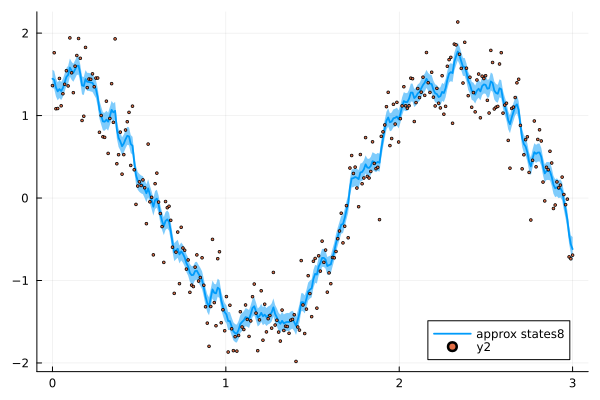

In [10]:
plot(time_interval,getindex.(mean.(inferred_state_VMPsmoothing),1),ribbon = sqrt.(getindex.(var.(inferred_state_VMPsmoothing),1)),label="approx states8", lw = 1.8)
scatter!(time_interval,getindex.(y_data,1), markersize=1.5)

## GP transition node

In [11]:
include("helperfunctions.jl")

gppredict (generic function with 1 method)

In [12]:
X_input = [x_init]
X_input = append!(X_input,y_data[1:N-1])
Y_data = getindex.(y_data,1)
d = 2

Random.seed!(12781)
Nu_x1 = 20; #number of points on the first axis  
Nu_x2 = 20; #number of points on the second axis
M = Nu_x1 * Nu_x2; #total number of searching points
Xu_grid =  vec(collect(Iterators.product(range(-3,3;length=Nu_x1), range(-3,3;length=Nu_x2))))
X = [[i...] for i in Xu_grid] #our grid 
niter = 20

N_sample_point =5 #number of sample points

pos = sort(randperm(length(X_input))[1:N_sample_point]) 
#sample points 
Xu_data = X_input[pos] # we'll update this set of inducing points
Yu_data = Y_data[pos]
;

In [13]:
Y_true = transition_function.(X);

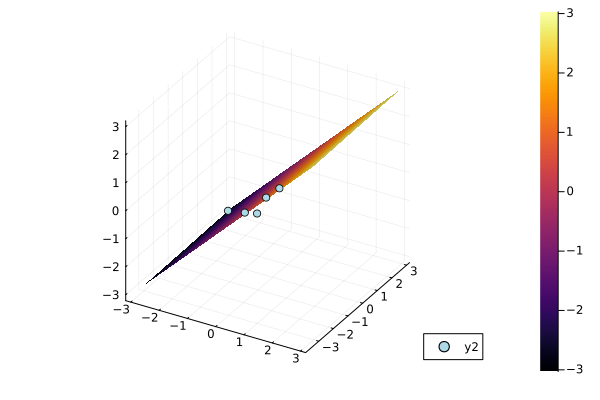

In [14]:
surface(getindex.(X,1), getindex.(X,2),getindex.(Y_true,1))
scatter!(getindex.(Xu_data,1),getindex.(Xu_data,2),Yu_data, color= :lightblue)

In [15]:
kernel_gp   =  1. * with_lengthscale(Matern52Kernel(),[2.2, 2.4]) 
meanfunc_2d = (x) -> 0.0
Kff_2d = kernelmatrix(kernel_gp,X_input,X_input) + 1e-12 * I;

In [16]:
μ_store_2d = [];
σ_store_2d = [];
y_acquisition_store_2d = [];
new_pos_store_2d = [];

In [17]:
for i=1:niter
    μ, Σ = gppredict(Xu_data, Yu_data, X_input, meanfunc_2d, kernel_gp, Kff_2d)
    #####
    y_acquisition = PI_acquisition(μ, Σ, Yu_data, 2.)
    #####
    #sample the function value at new position
    new_pos = findall(x -> x==maximum(y_acquisition), y_acquisition) 
    Y_data_new = Y_data[new_pos[1]] #+ σ_noise*randn()

    #add new data to dataset
    push!(Xu_data, X_input[new_pos[1]])
    push!(Yu_data, Y_data_new)
    push!(μ_store_2d,μ)
    push!(σ_store_2d, sqrt.(diag(Σ) .+ 1e-12))
    push!(y_acquisition_store_2d, y_acquisition)
    push!(new_pos_store_2d, new_pos[1])
end

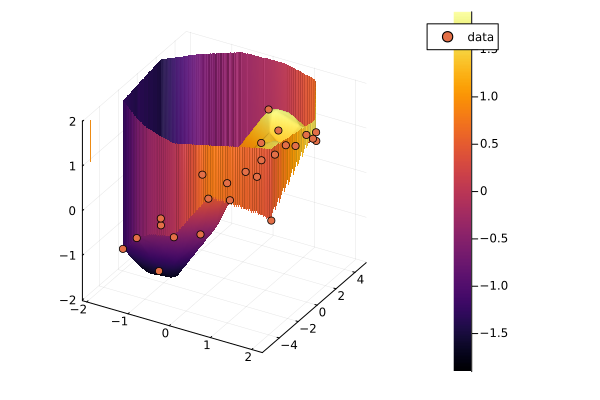

In [18]:
surface(getindex.(X_input,1), getindex.(X_input,2),μ_store_2d[end], label = "surrogate f")
# surface!(getindex.(X,1), getindex.(X,2),getindex.(Y_true,1))
scatter!(getindex.(Xu_data,1), getindex.(Xu_data,2), Yu_data, label = "data", legend = :outertopright)

In [19]:
M = length(Xu_data); #total number of inducing points 

Xu = Xu_data # optimal set of inducing points

Kuu = kernelmatrix(kernel_gp,Xu,Xu) + 1e-12*I;
Kuu_inverse = cholinv(Kuu) + 1e-12*I;
C = diageye(2)  #coregionalization matrix 
;

In [20]:
struct GPCache
    cache_matrices::Dict{Tuple{Symbol, Tuple{Int, Int}}, Matrix{Float64}}
    cache_vectors::Dict{Tuple{Symbol, Int}, Vector{Float64}}
end

GPCache() = GPCache(Dict{Tuple{Symbol, Tuple{Int, Int}}, Matrix{Float64}}(), Dict{Tuple{Symbol, Int}, Vector{Float64}}())

function getcache(cache::GPCache, label::Tuple{Symbol, Tuple{Int, Int}})
    return get!(() -> Matrix{Float64}(undef, label[2]), cache.cache_matrices, label)
end

function getcache(cache::GPCache, label::Tuple{Symbol, Int})
    return get!(() -> Vector{Float64}(undef, label[2]), cache.cache_vectors, label)
end

function mul_A_B!(cache::GPCache, A::Matrix, B, sizeA1::Int, sizeB2::Int)
    #multiply 2 matrices with different sizes 
    # sizeA1 = size(A,1) ;    sizeB2 = size(B,2)
    AB = getcache(cache, (:ABdiff, (sizeA1,sizeB2)))
    return mul!(AB, A, B)
end

function mul_A_B!(cache::GPCache, A::Matrix, B, size1::Int)
    #multiply 2 matrices with the same size
    #A, B are square matrices with a same size
    #size1 is size(A,1) = size(B,1)
    AB = getcache(cache, (:AB, (size1, size1)))
    return mul!(AB, A, B)
end

function mul_A_B_A!(cache::GPCache, A::Matrix, B::Matrix, size1::Int)
    #A, B are square matrices with a same size
    #size1 is size(A,1) = size(B,1)
    AB = getcache(cache, (:AB, (size1, size1)))
    ABA = getcache(cache, (:ABA, (size1, size1)))
    mul!(AB, A, B)

    return mul!(ABA, AB, A)
end
function mul_A_B_At!(cache::GPCache, A::Matrix, B::Matrix, sizeA1::Int, sizeB1::Int)
    # A: matrix with size (sizeA1,sizeB1)
    # B: matrix with size (sizeB1,sizeB1)
    
    AB = getcache(cache, (:AB, (sizeA1, sizeB1)))
    ABAt = getcache(cache, (:ABA, (sizeA1, sizeA1)))
    mul!(AB, A, B)

    return mul!(ABAt, AB, A')
end

function mul_A_v!(cache::GPCache, A::Matrix, v::Vector, sizeA1::Int)
    Av = getcache(cache, (:Av, sizeA1))
    return mul!(Av, A, v)
end

gpcache = GPCache()

function jdotavx(a::Array, b::Array)
    s = zero(eltype(a))
    @turbo for i ∈ eachindex(a, b)
        s += a[i] * b[i]
    end
    s
end

function create_blockmatrix(A,d,M)
    return [view(A,i:i+M-1,j:j+M-1) for j=1:M:M*d, i=1:M:M*d]
end

create_blockmatrix (generic function with 1 method)

In [21]:
kernel_value_Ψ0 = (x) -> getindex(kernelmatrix(kernel_gp,[x]),1)
compute_hessian_Ψ0 = (x) -> Zygote.hessian(kernel_value_Ψ0,x)
function approx_Ψ0_Laplace(q_x::T) where {T <: Distribution}
    x0, Σ = mean_cov(q_x)
    hessian_term = tr(compute_hessian_Ψ0(x0) * Σ)
    constant_terms = kernel_value_Ψ0(x0)
    return constant_terms + 0.5*hessian_term
end

kernel_value = (x,y) -> getindex(kernelmatrix(kernel_gp,[x],[y]),1)
compute_hessian_Ψ1 = (x,y) -> ForwardDiff.hessian((z) -> kernel_value(z,y),x)
hessian_vector = (x, Xu) -> [compute_hessian_Ψ1(x,xu) for xu in Xu]
function approx_Ψ1_Laplace!(Ψ1::Vector, Xu::Vector,q_x::T) where {T <: Distribution}
    x0, Σ = mean_cov(q_x)
    Ψ1 = 0.5*[tr(A * Σ) for A in hessian_vector(x0,Xu)]
    Ψ1 += [kernel_value(x0,xu) for xu in Xu]
    return Ψ1
end

cov_kernel_val = (x,y,z) -> getindex(kernelmatrix(kernel_gp,[x],[y]),1) * getindex(kernelmatrix(kernel_gp,[x],[z]),1)
compute_hessian_Ψ2 = (x,y,z) -> ForwardDiff.hessian((v) -> cov_kernel_val(v,y,z), x)

function approximate_Ψ2_Laplace(cache::GPCache,Xu::Vector,q_x::T) where {T <: Distribution}
    x0, Σ = mean_cov(q_x)
    m = length(Xu)
    Ψ2 = zeros(m,m)
    Ψ2_0 = kernelmatrix(kernel_gp,Xu,[x0]) * kernelmatrix(kernel_gp,[x0],Xu)
    for j=1:m
        for i=1:m
            Ψ2[i,j] = Ψ2_0[i,j] + 0.5 * tr(mul_A_B!(cache, compute_hessian_Ψ2(x0,Xu[i],Xu[j]), Σ, length(x0)))
        end
    end
    return Ψ2 
end

Afunc = (x) -> kron(C,kernelmatrix(kernel_gp,[x],[x])[] - getindex(kernelmatrix(kernel_gp,[x],Xu) * Kuu_inverse * kernelmatrix(kernel_gp,Xu,[x]),1))
Bfunc = (x) -> kron(C,kernelmatrix(kernel_gp, [x], Xu) * Kuu_inverse)

#48 (generic function with 1 method)

In [22]:
struct GPTransitionMeta{I,T}
    M           :: I    # number of inducing points 
    D           :: I    # number of dimension
    Kuu_inverse :: T  
    C           :: T    # co-regionalization matrix 
    GPCache     :: GPCache
end
getNumberInducingPoints(meta::GPTransitionMeta) = meta.M 
getNumberDimensions(meta::GPTransitionMeta) = meta.D
getinverseKuu(meta::GPTransitionMeta) = meta.Kuu_inverse
getCoregionalizationMatrix(meta::GPTransitionMeta) = meta.C
getGPCache(meta::GPTransitionMeta) = meta.GPCache

getGPCache (generic function with 1 method)

In [23]:
struct GPTransition end 

@node GPTransition Stochastic [ out, in, u , γ] ## out: x_t , in: x_{t-1},  u: inducing points , γ: process noise 

@rule GPTransition(:out, Marginalisation) (q_in::MultivariateNormalDistributionsFamily, q_u::MultivariateNormalDistributionsFamily,q_γ::PointMass, meta::GPTransitionMeta,) = begin
    M = getNumberInducingPoints(meta) #number of inducing points
    D = getNumberDimensions(meta) #dimension 
    Kuu_inverse = getinverseKuu(meta)

    μ_u = mean(q_u)
    W = mean(q_γ) 
    @inbounds μ_u = [view(μ_u,i:i+M-1) for i=1:M:M*D] 
    Ψ1 = getcache(getGPCache(meta),(:Ψ1, M))
    Ψ1 = approx_Ψ1_Laplace!(Ψ1, Xu,q_in)
    μ_y = getcache(getGPCache(meta), (:μ_y, D))
    μ_u_transformed = getcache(getGPCache(meta), (:μ_u_transformed, M))
    for (i,μ_u_entry) in enumerate(μ_u)
        mul!(μ_u_transformed,Kuu_inverse,μ_u_entry)
        @inbounds μ_y[i] = jdotavx(Ψ1,μ_u_transformed)
    end
    return MvNormalMeanPrecision(μ_y, W)
end

@rule GPTransition(:out, Marginalisation) (q_in::MultivariateNormalDistributionsFamily, q_u::MultivariateNormalDistributionsFamily,q_γ::Wishart, meta::GPTransitionMeta,) = begin
    M = getNumberInducingPoints(meta) #number of inducing points
    D = getNumberDimensions(meta) #dimension 
    Kuu_inverse = getinverseKuu(meta)

    μ_u = mean(q_u)
    W = mean(q_γ) 
    @inbounds μ_u = [view(μ_u,i:i+M-1) for i=1:M:M*D] 
    Ψ1 = getcache(getGPCache(meta),(:Ψ1, M))
    Ψ1 = approx_Ψ1_Laplace!(Ψ1, Xu,q_in)
    μ_y = getcache(getGPCache(meta), (:μ_y, D))
    μ_u_transformed = getcache(getGPCache(meta), (:μ_u_transformed, M))
    for (i,μ_u_entry) in enumerate(μ_u)
        mul!(μ_u_transformed,Kuu_inverse,μ_u_entry)
        @inbounds μ_y[i] = jdotavx(Ψ1,μ_u_transformed)
    end
    return MvNormalMeanPrecision(μ_y, W)
end

@rule GPTransition(:in, Marginalisation) (q_out::MultivariateNormalDistributionsFamily, q_u::MultivariateNormalDistributionsFamily,q_γ::PointMass, meta::GPTransitionMeta) = begin
    μ_y, Σ_y = mean_cov(q_out)
    μ_u, Σ_u = mean_cov(q_u)
    W = mean(q_γ) 
    E_logγ = log(det(W))
    D = getNumberDimensions(meta)
    M = getNumberInducingPoints(meta)
    cache = getGPCache(meta)
    
    neg_log_backwardmess = (x) -> -(-0.5*d * log2π + 0.5*E_logγ - 0.5  * (tr(W*(Afunc(x) + Σ_y + Bfunc(x)*Σ_u*Bfunc(x)')) + (μ_y - Bfunc(x)*μ_u)' * W * (μ_y - Bfunc(x)*μ_u)))
    res = optimize(neg_log_backwardmess,zeros(D))
    m_z = res.minimizer
    W_z = Zygote.hessian(neg_log_backwardmess, m_z) 
    return MvNormalWeightedMeanPrecision(W_z * m_z, W_z)
end

@rule GPTransition(:u, Marginalisation) (q_out::MultivariateNormalDistributionsFamily, q_in::MultivariateNormalDistributionsFamily, q_γ::PointMass,meta::GPTransitionMeta) = begin
    W = mean(q_γ)
    μ_y = mean(q_out)
    D = getNumberDimensions(meta)
    M = getNumberInducingPoints(meta)
    Kuu_inverse = getinverseKuu(meta)
    C = getCoregionalizationMatrix(meta)
    cache = getGPCache(meta)
    
    #Remember to change Unit_Normal
    Ψ1 = getcache(cache,(:Ψ1,M))
    # Ψ2 = getcache(cache,(:Ψ2, (M,M)))
    Ψ1 = approx_Ψ1_Laplace!(Ψ1,Xu,q_in)
    Ψ2 = approximate_Ψ2_Laplace(gpcache,Xu, q_in)

    #we'll use NormalWeightedMeanPrecision
    ξ_u = Float64[]
    Ψ1_transformed = mul_A_B!(cache,Kuu_inverse,Ψ1,M,1) #Ψ1_transformed = Kuu_inverse * Ψ1
    μ_y_transformed = W * μ_y 
    for mu_y in μ_y_transformed
        ξ = mu_y .* Ψ1_transformed
        append!(ξ_u, ξ)
    end

    Ψ2_transformed = mul_A_B_A!(cache, Kuu_inverse, Ψ2,M) # Ψ2_transformed = Kuu_inverse * Ψ2 * Kuu_inverse
    W_u = getcache(cache, (:W_u, (D*M,D*M)))
    kron!(W_u,W, Ψ2_transformed)
    return MvNormalWeightedMeanPrecision(ξ_u, W_u)
end

@rule GPTransition(:γ, Marginalisation) (q_out::MultivariateNormalDistributionsFamily, q_in::MultivariateNormalDistributionsFamily, q_u::MultivariateNormalDistributionsFamily, meta::GPTransitionMeta,) = begin
    μ_y, Σ_y = mean_cov(q_out)
    μ_u, Σ_u = mean_cov(q_u)

    D = getNumberDimensions(meta)  #dimension
    M = getNumberInducingPoints(meta) #number of inducing points
    C = getCoregionalizationMatrix(meta)
    cache = getGPCache(meta)
    μ_u = [view(μ_u,i:i+M-1) for i=1:M:M*D]  
    Σ_u = create_blockmatrix(Σ_u,D,M)
    Kuu_inverse = getinverseKuu(meta)

    Ψ1 = getcache(cache,(:Ψ1, M))
    # Ψ2 = getcache(cache,(:Ψ2, (M,M)))
    Ψ1 = approx_Ψ1_Laplace!(Ψ1,Xu,q_in)
    Ψ2 = approximate_Ψ2_Laplace(gpcache,Xu, q_in)

    trace_A = mul_A_B!(cache,Kuu_inverse,Ψ2,M) |> tr #trA =tr(Kuu_inverse * Ψ2)
    I1 = (approx_Ψ0_Laplace(q_in) - trace_A) .* C # kron(C, getindex(Ψ0,1) - trace_A)

    B_mat = mul_A_B!(cache,Kuu_inverse,Ψ1,M,1) #B = Ψ1 * Kuu_inverse
    Ψ2_transformed = mul_A_B_A!(cache, Kuu_inverse, Ψ2,M) # Kuu_inverse * Ψ2 * Kuu_inverse
    E = [getindex(B_mat' * i,1) for i in μ_u]
    Ψ_5 = getcache(cache,(:Ψ_5,(D,D)))
    for j=1:D
        for i=1:D
            Ψ_5[i,j] = tr((μ_u[i]*μ_u[j]' + Σ_u[i,j]) * Ψ2_transformed)
        end
    end
    I2 = μ_y * μ_y' + Σ_y - μ_y * E' - E * μ_y' + Ψ_5 
    return WishartMessage(D+2, I1 + I2)
end

@average_energy GPTransition (q_out::MultivariateNormalDistributionsFamily, q_in::MultivariateGaussianDistributionsFamily, q_u::MultivariateNormalDistributionsFamily, q_γ::PointMass, meta::GPTransitionMeta,) = begin
    μ_y, Σ_y = mean_cov(q_out)
    μ_u, Σ_u = mean_cov(q_u)
    W = mean(q_γ)
    E_logW = log(det(W))

    D = getNumberDimensions(meta)  #dimension
    M = getNumberInducingPoints(meta) #number of inducing points
    C = getCoregionalizationMatrix(meta)
    cache = getGPCache(meta)
    μ_u = [view(μ_u,i:i+M-1) for i=1:M:M*D]  
    Σ_u = create_blockmatrix(Σ_u,D,M)
    Kuu_inverse = getinverseKuu(meta)

    Ψ1 = getcache(cache,(:Ψ1, M))
    # Ψ2 = getcache(cache,(:Ψ2, (M,M)))
    Ψ1 = approx_Ψ1_Laplace!(Ψ1,Xu,q_in)
    Ψ2 = approximate_Ψ2_Laplace(gpcache,Xu, q_in)

    trace_A = mul_A_B!(cache,Kuu_inverse,Ψ2,M) |> tr #trA =tr(Kuu_inverse * Ψ2)
    I1 = (approx_Ψ0_Laplace(q_in) - trace_A) .* C # kron(C, getindex(Ψ0,1) - trace_A)

    B_mat = mul_A_B!(cache,Kuu_inverse,Ψ1,M,1) #B = Ψ1 * Kuu_inverse
    Ψ2_transformed = mul_A_B_A!(cache, Kuu_inverse, Ψ2,M) # Kuu_inverse * Ψ2 * Kuu_inverse
    E = [getindex(B_mat' * i,1) for i in μ_u]
    Ψ_5 = getcache(cache,(:Ψ_5,(D,D)))
    for j=1:D
        for i=1:D
            Ψ_5[i,j] = tr((μ_u[i]*μ_u[j]' + Σ_u[i,j]) * Ψ2_transformed)
        end
    end
    I2 = μ_y * μ_y' + Σ_y - μ_y * E' - E * μ_y' + Ψ_5 

    return 0.5*tr(W*I1) + 0.5*D*log2π - 0.5*E_logW + 0.5 * tr(W * I2)
end

In [24]:
@model function pendulum_GP(n,Kuu_inverse_big,Q,P)
    y = datavar(Vector{Float64}, n)
    x = randomvar(n)

    u ~ MvNormalWeightedMeanPrecision(zeros(size(Kuu_inverse_big,1)), Kuu_inverse_big)
    # w ~ Wishart(4, 10*diageye(2))
    x_prior ~ MvNormalMeanCovariance([1.6,0], 0.1*diageye(2))
    x_prev = x_prior
    for i=1:n
        x[i] ~ GPTransition(x_prev,u,[9 -0.1;-0.1 10]) where { q = MeanField() }  #mean-field assumption
        y[i] ~ MvNormalMeanCovariance(x[i], P)
        x_prev = x[i]
    end
end

In [25]:
@meta function gpssm_meta(M,D,Kuu_inverse,C,gpcache)
    # GPTransition(x,u,w) -> GPTransitionMeta(M,D,Kuu_inverse,C,gpcache)
    GPTransition(x,u) -> GPTransitionMeta(M,D,Kuu_inverse,C,gpcache)
end

gpssm_meta (generic function with 1 method)

In [26]:
@rule MvNormalWeightedMeanPrecision(:out, Marginalisation) (q_ξ::PointMass, q_Λ::PointMass, ) = begin 
    return MvNormalWeightedMeanPrecision(mean(q_ξ),mean(q_Λ))
end

In [27]:
niter = 20;

infer_result_gp = inference(
    model = pendulum_GP(N,kron(C,Kuu_inverse),Q,P),
    iterations = niter,
    data = (y = y_data,),
    initmarginals = (u = MvNormalWeightedMeanPrecision(zeros(size(kron(C,Kuu),1)), kron(C,Kuu_inverse)), x = MvNormalMeanCovariance([1.6,0], 0.1*diageye(2)),),# w = Wishart(4,10*diageye(2)),),
    meta = gpssm_meta(M,d,Kuu_inverse,C,gpcache),
    returnvars = (x = KeepEach(), u = KeepLast(),),
    free_energy = true,
    showprogress = true
) 

Progress:  10%|████▏                                    |  ETA: 0:01:47

Progress:  15%|██████▏                                  |  ETA: 0:01:23

Progress:  20%|████████▎                                |  ETA: 0:01:08

Progress:  25%|██████████▎                              |  ETA: 0:00:59

Progress:  30%|████████████▎                            |  ETA: 0:00:51

Progress:  35%|██████████████▍                          |  ETA: 0:00:46

Progress:  40%|████████████████▍                        |  ETA: 0:00:41

Progress:  45%|██████████████████▌                      |  ETA: 0:00:36

Progress:  50%|████████████████████▌                    |  ETA: 0:00:32

Progress:  55%|██████████████████████▌                  |  ETA: 0:00:28

Progress:  60%|████████████████████████▋                |  ETA: 0:00:25

Progress:  65%|██████████████████████████▋              |  ETA: 0:00:21

Progress:  70%|████████████████████████████▊            |  ETA: 0:00:18

Progress:  75%|██████████████████████████████▊          |  ETA: 0:00:15

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:12

Progress:  85%|██████████████████████████████████▉      |  ETA: 0:00:09

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:06

Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


Inference results:
  Posteriors       | available for (u, x)
  Free Energy:     | Real[3.81939e6, 6.97912e5, 72942.5, 16284.0, 6051.01, 2757.13, 1251.46, 687.126, 519.395, 467.432, 454.065, 449.678, 448.63, 448.023, 447.905, 447.494, 448.2, 447.862, 447.718, 447.621]


In [28]:
inferred_state_GP = infer_result_gp.posteriors[:x];
qu = infer_result_gp.posteriors[:u];

In [29]:
μ_u_concat = mean(qu);
μ_u = reshape(μ_u_concat,M,2)'
μ_u = [μ_u[:,i] for i=1:M]
;

In [30]:
function predict(X_train,y_train,x_test,kernel)
    K_train = kernelmatrix(kernel,X_train,X_train)
    K_test_train = kernelmatrix(kernel,x_test,X_train)
    K_test = kernelmatrix(kernel,x_test,x_test)

    invK_train = inv(K_train)
    μ_test = K_test_train * invK_train * y_train  
    σ_test = K_test - K_test_train * invK_train * K_test_train'
    return μ_test, σ_test
end

predict (generic function with 1 method)

In [31]:
y1_predict = predict(Xu, getindex.(μ_u, 1), X, kernel_gp);
y2_predict = predict(Xu, getindex.(μ_u, 2), X, kernel_gp);

y1u_predict = predict(Xu_data, Yu_data, X, kernel_gp);
y_true_val = transition_function.(X);

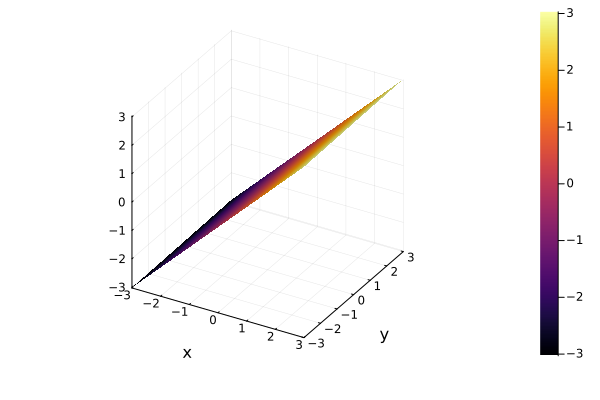

In [32]:
surface(getindex.(X, 1),getindex.(X, 2), getindex.(y_true_val, 1), label = "true")
xlabel!("x")
ylabel!("y")

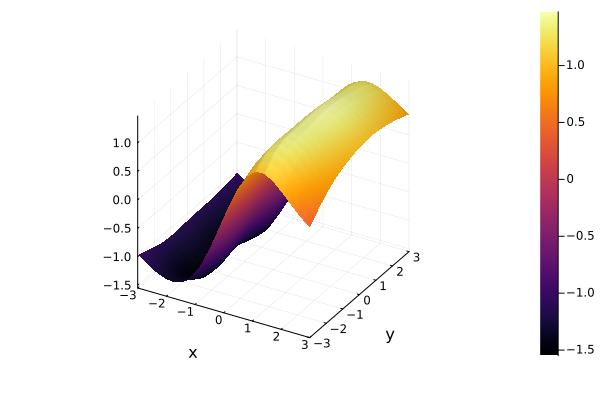

In [33]:
surface(getindex.(X, 1),getindex.(X, 2), y1_predict, label="estimated")
# surface!(getindex.(X, 1),getindex.(X, 2), getindex.(y_true_val, 1), label = "true"; camera = (40,20))
xlabel!("x")
ylabel!("y")

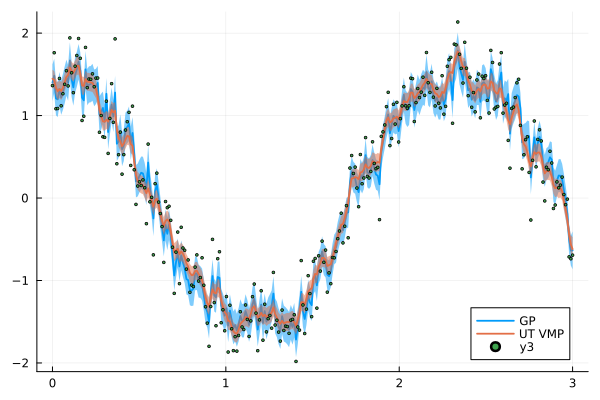

In [34]:
plot(time_interval,getindex.(mean.(inferred_state_GP[end]),1),ribbon = sqrt.(getindex.(var.(inferred_state_GP[end]),1)),label="GP", lw = 1.8)
plot!(time_interval,getindex.(mean.(inferred_state_VMPsmoothing),1),ribbon = sqrt.(getindex.(var.(inferred_state_VMPsmoothing),1)),label="UT VMP", lw = 1.8)
scatter!(time_interval,getindex.(y_data,1), markersize=1.5)

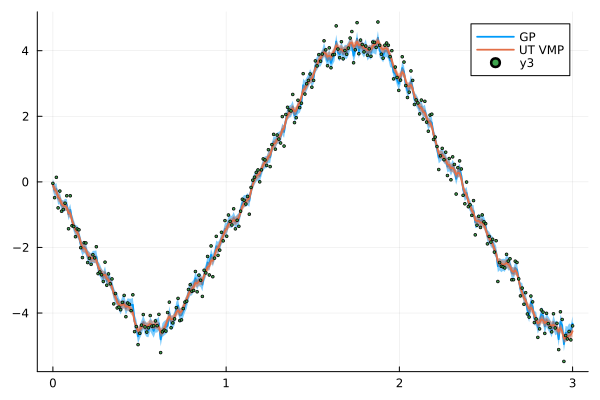

In [35]:
plot(time_interval,getindex.(mean.(inferred_state_GP[end]),2),ribbon = sqrt.(getindex.(var.(inferred_state_GP[end]),2)),label="GP ", lw = 1.8)
plot!(time_interval,getindex.(mean.(inferred_state_VMPsmoothing),2),ribbon = sqrt.(getindex.(var.(inferred_state_VMPsmoothing),2)),label="UT VMP", lw = 1.8)
scatter!(time_interval,getindex.(y_data,2), markersize=1.5)

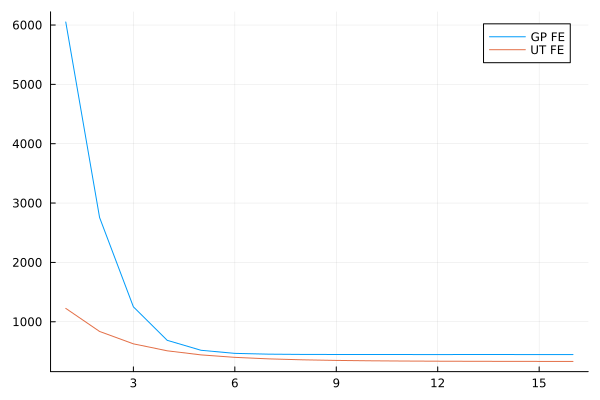

In [44]:
plot(infer_result_gp.free_energy[5:end],label="GP FE")
plot!(infer_result_VMPsmoothing.free_energy[5:end], label="UT FE")

In [ ]:

# autoupdates = @autoupdates begin
# 	μ_s, Σ_s = mean_cov(q(s))
# 	μ_n, Σ_n = mean_cov(q(n))
# end;

In [81]:
# filtering_result = rxinference(
#     model = pendulum_GP(N,kron(C,Kuu_inverse),Q,P),
#     data = (y = y_data,),
#     initmarginals = (u = MvNormalWeightedMeanPrecision(zeros(size(kron(C,Kuu),1)), kron(C,Kuu_inverse)), x = MvNormalMeanCovariance([1.6,0], 0.1*diageye(2)),),# w = Wishart(4,10*diageye(2)),),
#     meta = gpssm_meta(M,d,Kuu_inverse,C,gpcache),
#     returnvars    = (:x, :u),
#     keephistory   = 1,
#     historyvars   = (x = KeepLast(), u = KeepLast()),
#     autostart     = true
# )

AssertionError: AssertionError: Invalid `update!` call: size of datavar array and data must match: `y` has size (300,) and data has size (2,). 
